In [46]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
fig_path      = '../figures/'
data_path     = '../data/'

In [47]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd 
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from proj_utils import *
from mapping_utils import *

In [48]:
nao_c = '#dc267f'
eap_c = '#fe6100'

## (1) Open SLP data, do some processing

In [49]:
ds_slp = xr.open_dataset(data_path + 'north_atlantic_slp.nc')

ds_slp = ds_slp.sel(expver = slice(0,1)).squeeze()
ds_slp = ds_slp.drop_vars('expver')
ds_slp = ds_slp.sel(time = slice('1993-01-01','2022-12-01'))
ds_slp = ds_slp.sortby(ds_slp.latitude)

ds_slp = seasonal_detrend(ds_slp)

## (2) Open NAO and EAP timeseries (which we computed in slp_modes.ipynb)

In [50]:
nao_ts = xr.open_dataarray(data_path + 'nao_era5_timeseries.nc')
eap_ts = xr.open_dataarray(data_path + 'eap_era5_timeseries.nc')

nao_sp = xr.open_dataarray(data_path + 'nao_era5_spatial_pattern.nc')
eap_sp = xr.open_dataarray(data_path + 'eap_era5_spatial_pattern.nc')

## (3) For each window, compute NAO and EAP

In [51]:
window_sz = 48 # 4 yrs

In [52]:
nao_ = nao_sp # This is the full time period NAO spatial pattern
eap_ = eap_sp # This is the full time period EAP spatial pattern

In [53]:
# --- For each window (of size window_sz), compute EOFS and choose which EOF (1 or 2) is NAO ---
# --- Save percent variance explained by NAO and EAP for later ---
nao_mode = []; nao_pv = []; eap_pv = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for t in range(len(ds_slp['msl'])-window_sz):
        slp_temp = ds_slp['msl'].sel(time = slice(ds_slp['msl'].time[t].data, ds_slp['msl'].time[t+window_sz].data))
        eofs_temp, pcs_temp, per_var_temp, _ = calc_eofs(slp_temp, num_modes=4)
        corr_nao_temp = xr.corr(nao_,eofs_temp[0,:,:])
        corr_eap_temp = xr.corr(nao_,eofs_temp[1,:,:])
        if abs(corr_nao_temp) > abs(corr_eap_temp):
            mode = 1 
            nao_pv.append(per_var_temp[0].data)
            eap_pv.append(per_var_temp[1].data)
        else:
            mode = 2
            nao_pv.append(per_var_temp[1].data)
            eap_pv.append(per_var_temp[0].data)
        nao_mode.append(mode)

In [54]:
# --- Convert everything to arrays for plotting ---
nao_pv   = np.array(nao_pv)
eap_pv   = np.array(eap_pv)
nao_mode = np.array(nao_mode)

## (4) For each window, calculate location of Azores High

In [55]:
# --- Create dataset of only ocean SLP (remove land) ---
slp_ocn = ds_slp
slp_ocn.msl.data[slp_ocn.lsm.data > 0.15] = np.nan
slp_ocn = slp_ocn['msl']

In [61]:
# --- Longitude of Subtropical High ---
azores_high_lon = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for c in range(len(slp_ocn.time)-(window_sz)):
        slp_temp = slp_ocn.sel(time = slice(slp_ocn.time[c].data,slp_ocn.time[c+window_sz].data))
        eofs_temp, pcs_temp, per_var_temp, _ = calc_eofs(slp_temp, num_modes=4)
        nao_ = eofs_temp[nao_mode[c]-1,:,:]
        nao_subtrop = nao_.sel(longitude = slice(-60,0), latitude = slice(25,45))
        lon_mesh, lat_mesh = np.meshgrid(nao_subtrop.longitude, nao_subtrop.latitude)
        nao_flat = nao_subtrop.data.flatten()
        lon_flat = lon_mesh.flatten()
        max_idx = np.argmax(abs(nao_flat))
        max_lon = lon_flat[max_idx]
        azores_high_lon.append(max_lon)

In [73]:
# --- Longitude of EAP CoA ---
# --- ** to do ** fold together with previous 
eap_lon = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for c in range(len(slp_ocn.time)-(window_sz)):
        slp_temp = slp_ocn.sel(time = slice(slp_ocn.time[c].data,slp_ocn.time[c+window_sz].data))
        eofs_temp, pcs_temp, per_var_temp, _ = calc_eofs(slp_temp, num_modes=4)
        eap_ = eofs_temp[2-nao_mode[c],:,:]
        eap_subtrop = eap_.sel(longitude = slice(-60,-10), latitude = slice(35,70))
        lon_mesh, lat_mesh = np.meshgrid(eap_subtrop.longitude, eap_subtrop.latitude)
        eap_flat = eap_subtrop.data.flatten()
        lon_flat = lon_mesh.flatten()
        max_idx = np.argmax(abs(eap_flat))
        max_lon = lon_flat[max_idx]
        eap_lon.append(max_lon)

## (5) Plot Timeseries

In [25]:
time_cent = ds_slp.time[24:-24] # This is the time at the centre of each period

In [75]:
# --- Load climatological NAO/EAP patterns to plot means ---
per_var_full   = xr.open_dataarray(data_path + 'slp_eofs_per_var.nc')
eap_full_ts_lon = -21
nao_full_ts_lon = -27

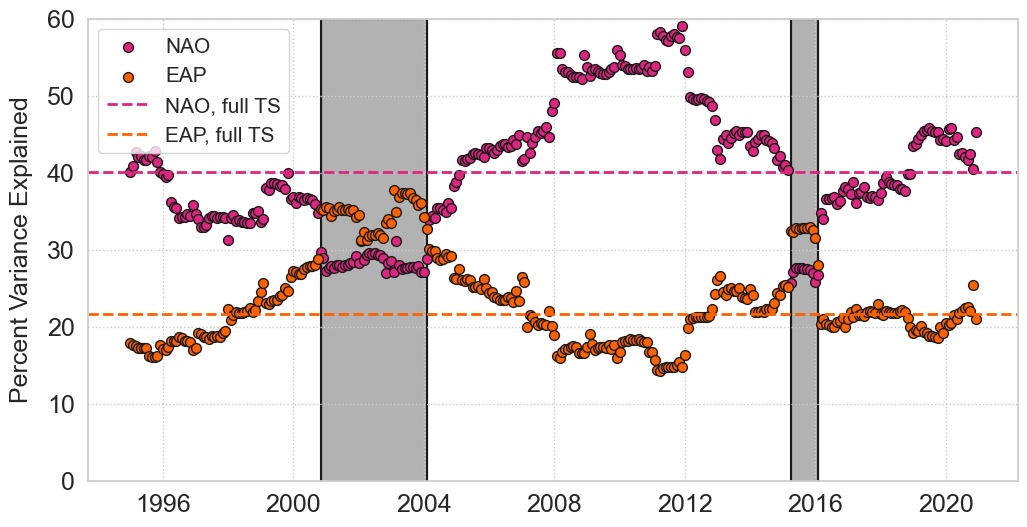

In [66]:
# --- EAP AND NAO PERCENT VARIANCE ---
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig     = plt.figure(figsize=(12, 6))

pv_all  = plt.scatter(time_cent,(nao_pv)*100, 50, c = nao_c, edgecolors= 'k', label = 'NAO')
pv_all  = plt.scatter(time_cent,(eap_pv)*100, 50, c = eap_c, edgecolors= 'k', label = 'EAP')

pv_nao_mn = plt.axhline(per_var_full[0]*100, color = nao_c, linewidth = 2, linestyle = '--', label = 'NAO, full TS')
pv_eap_mn = plt.axhline(per_var_full[1]*100, color = eap_c, linewidth = 2, linestyle = '--', label = 'EAP, full TS')

plt.axvspan(time_cent[nao_mode == 2][0].data,time_cent[nao_mode == 2][39].data, alpha=0.3, color='black',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][0].data,color='k',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][39].data,color='k',zorder = 0)

plt.axvspan(time_cent[nao_mode == 2][40].data,time_cent[nao_mode == 2][-1].data, alpha=0.3, color='black',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][40].data,color='k',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][-1].data,color='k',zorder = 0)

ytix = plt.yticks(fontsize=18)
xtix = plt.xticks(fontsize=18)

ylab = plt.ylabel('Percent Variance Explained', fontsize = 18, labelpad=10)
plt.ylim(0,60)
plt.legend(fontsize = 15)
plt.savefig(fig_path + 'eap_nao_pv.png', format='png', bbox_inches="tight",dpi=500)

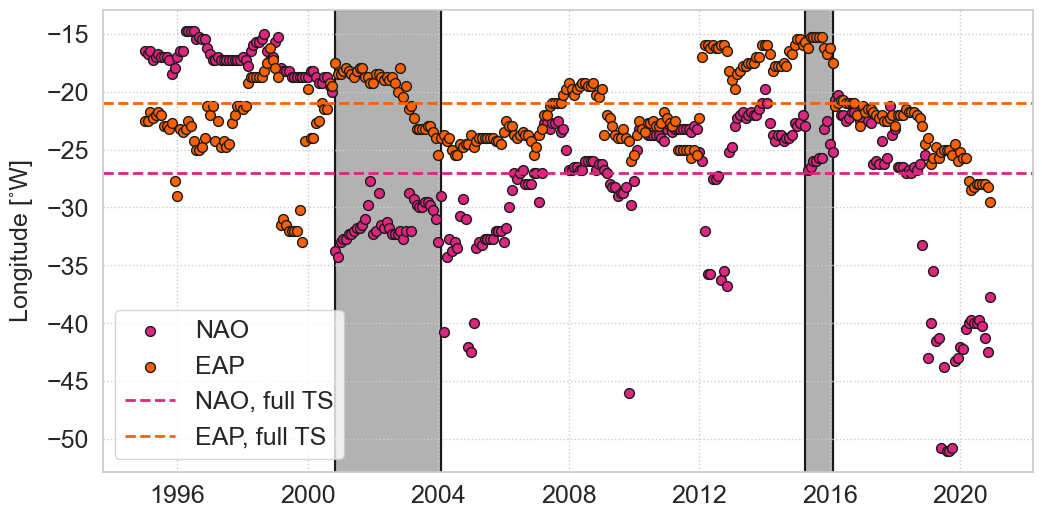

In [77]:
# --- NAO AND EAP LONGITUDE ---
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig     = plt.figure(figsize=(12, 6))

sh_lon  = plt.scatter(time_cent,azores_high_lon, 50, c = nao_c, edgecolors= 'k', label = 'NAO')
ea_lon  = plt.scatter(time_cent,eap_lon, 50, c = eap_c, edgecolors= 'k', label = 'EAP')

lon_nao_mn = plt.axhline(nao_full_ts_lon, color = nao_c, linewidth = 2, linestyle = '--', label = 'NAO, full TS')
lon_eap_mn = plt.axhline(eap_full_ts_lon, color = eap_c, linewidth = 2, linestyle = '--', label = 'EAP, full TS')


plt.axvspan(time_cent[nao_mode == 2][0].data,time_cent[nao_mode == 2][39].data, alpha=0.3, color='black',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][0].data,color='k',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][39].data,color='k',zorder = 0)

plt.axvspan(time_cent[nao_mode == 2][40].data,time_cent[nao_mode == 2][-1].data, alpha=0.3, color='black',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][40].data,color='k',zorder = 0)
plt.axvline(time_cent[nao_mode == 2][-1].data,color='k',zorder = 0)

ytix = plt.yticks(fontsize=18)
xtix = plt.xticks(fontsize=18)

ylab = plt.ylabel('Longitude [˚W]', fontsize = 18, labelpad=10)
#plt.ylim(0,60)
plt.legend(fontsize = 18)
plt.savefig(fig_path + 'eap_nao_longitudes.png', format='png', bbox_inches="tight",dpi=500)

## (5) Save info for later use

In [44]:
ds_modes = xr.Dataset(
    {
        'nao_pv'  : ('time_c', nao_pv*100,{
            'long_name': 'NAO Percent Variance Explained',
            'units': '%',
            'description': 'Percent variance explained by NAO-like mode for each (48 mn) window, centered at time_c'
        }),
        'eap_pv'  : ('time_c', eap_pv*100,{
            'long_name': 'EAP Percent Variance Explained',
            'units': '%',
            'description': 'Percent variance explained by EAP-like mode for each (48 mn) window, centered at time_c'
        }),
        'nao_mode': ('time_c', nao_mode,{
            'long_name': 'NAO Mode',
            'units': '-',
            'description': 'Whether NAO is leading mode (1) or second mode (2)'
        }),
    },
    coords={
        'time_c': time_cent,
    }
)

In [81]:
ds_lons = xr.Dataset(
    {
        'nao_sh_long'  : ('time_c', np.array(azores_high_lon),{
            'long_name': 'Longitude of Subtropical High CoA',
            'units': '˚W',
            'description': 'Longitude of Subtropical High Centre of Action of NAO-like mode for each (48 mn) window, centered at time_c'
        }),
        'eap_high_long'  : ('time_c', np.array(eap_lon),{
            'long_name': 'Longitude of EAP High CoA',
            'units': '˚W',
            'description': 'Longitude of EAP High Centre of Action of EAP-like mode for each (48 mn) window, centered at time_c'
        })
    },
    coords={
        'time_c': time_cent,
    }
)

In [83]:
# --- Save to NC Files (commented b/c only need to do once)
#ds_modes.to_netcdf(data_path + 'nao_eap_per_var.nc')
#ds_lons.to_netcdf(data_path + 'nao_eap_coa_lons.nc')